# Quotation Scoring Modeling (ML)

--------------------------

#### This notebook aims to explore the dataset containing supplier responses and to build a machine learning model to predict the likelihood that each proposal will be converted into a customer sale.

In [1]:
import pandas as pd
import sqlite3

# Connecting to the SQL database
conn = sqlite3.connect("../data/quotations.db")

# Loading training/validation and test data tables
df = pd.read_sql_query("SELECT * FROM training_quotations", conn)
df_test = pd.read_sql_query("SELECT * FROM real_quotation_data", conn)
conn.close()

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  int64  
 1   unit_price            10000 non-null  float64
 2   delivery_days         10000 non-null  int64  
 3   performance_score     10000 non-null  float64
 4   response_time         10000 non-null  float64
 5   rfq_complexity_score  10000 non-null  float64
 6   is_urgent             10000 non-null  int64  
 7   is_custom             10000 non-null  int64  
 8   won                   10000 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 703.3 KB


In [7]:
df.sample(5)

,id,unit_price,delivery_days,performance_score,response_time,rfq_complexity_score,is_urgent,is_custom,won
3838,3839,14.29,7,0.15,40.09,3.81,0,1,0
7032,7033,9.74,5,0.35,63.96,2.85,1,0,0
7394,7395,8.18,6,0.65,55.38,2.96,0,0,0
3309,3310,13.85,10,1.78,3.10,2.73,0,0,1
1564,1565,10.77,10,0.58,64.86,3.01,0,0,0


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    588 non-null    int64  
 1   unit_price            588 non-null    float64
 2   delivery_days         588 non-null    int64  
 3   performance_score     588 non-null    float64
 4   response_time         588 non-null    float64
 5   rfq_complexity_score  588 non-null    float64
 6   is_urgent             588 non-null    int64  
 7   is_custom             588 non-null    int64  
 8   won                   0 non-null      object 
dtypes: float64(4), int64(4), object(1)
memory usage: 41.5+ KB


In [5]:
df_test.head()

# Target 'won' is NULL

,id,unit_price,delivery_days,performance_score,response_time,rfq_complexity_score,is_urgent,is_custom,won
0,1,12.75,9,4.05,2.0,3.14,0,0,None
1,2,11.95,6,4.98,2.0,3.11,1,0,None
2,3,11.89,8,4.22,2.0,2.91,1,0,None
3,4,13.08,6,3.49,2.0,3.25,0,0,None
4,5,13.02,10,4.41,2.0,3.22,0,0,None


# EDA + Statistics

----------------------

##### Our prototype currently uses only synthetic data to simulate the real-world behavior of the end-to-end data workflow. For this reason, no exploratory data analysis or descriptive statistics will be performed at this stage—such as pattern identification, outlier detection, missing value checks, or data acquisition inconsistencies—since all input data is controlled and designed to be modeling-ready.
##### To review the data generation mechanisms, refer to the scripts ```synthetic_data.py```, ```generate_training_dataset.py```, and ```simulate_quotations.py``` in the ```./src/utils/ directory```.

-----------------------

# Modeling (Binary Classification)

#### Data Preparation & Preprocessing
We began by splitting the dataset into training and validation sets, preserving class distribution through stratified sampling. To address class imbalance, we applied **undersampling** on the training set. A **MinMaxScaler** was then used to normalize continuous, non-binary features. Both scaled and raw versions of the datasets were stored to allow flexibility when training models with different preprocessing needs (e.g., tree-based models that don’t require feature scaling).

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# Define feature and target columns
binary_columns = ['is_urgent', 'is_custom']
non_binary_columns = ['unit_price', 'delivery_days', 'performance_score', 'response_time', 'rfq_complexity_score']

X = df.drop(columns=['id', 'won'])
y = df['won']

# Train-validation split
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Undersample only the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = undersampler.fit_resample(X_train_full, y_train)

# Apply MinMaxScaler only on non-binary columns
scaler = MinMaxScaler()
X_train_us_scaled = X_train_us.copy()
X_val_scaled = X_val_full.copy()

X_train_us_scaled[non_binary_columns] = scaler.fit_transform(X_train_us[non_binary_columns])
X_val_scaled[non_binary_columns] = scaler.transform(X_val_full[non_binary_columns])

# Store raw (unscaled) versions for tree-based models
X_train_us_raw = X_train_us.copy()
X_val_raw = X_val_full.copy()


#### Model Training & Evaluation
We trained four different classification models: Logistic Regression, Random Forest, XGBoost, and LightGBM. Scaled features were used with Logistic Regression, while raw features were used with tree-based models. For each model, we evaluated performance on both training and validation datasets using classification reports to assess metrics like precision, recall, and F1-score.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define models and data
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "X_train": X_train_us_scaled,
        "X_val": X_val_scaled,
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "X_train": X_train_us_raw,
        "X_val": X_val_raw,
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42),
        "X_train": X_train_us_raw,
        "X_val": X_val_raw,
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1),
        "X_train": X_train_us_raw,
        "X_val": X_val_raw,
    }
}

# Train and evaluate each model
for name, config in models.items():
    model = config["model"]
    X_train = config["X_train"]
    X_val = config["X_val"]

    print(f"\n🔹 {name}")
    model.fit(X_train, y_train_us)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print("Training classification report:")
    print(classification_report(y_train_us, y_train_pred))

    print("Validation classification report:")
    print(classification_report(y_val, y_val_pred))



🔹 Logistic Regression
Training classification report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1051
           1       0.85      0.94      0.89      1051

    accuracy                           0.89      2102
   macro avg       0.89      0.89      0.89      2102
weighted avg       0.89      0.89      0.89      2102

Validation classification report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1737
           1       0.43      0.94      0.59       263

    accuracy                           0.83      2000
   macro avg       0.71      0.88      0.74      2000
weighted avg       0.92      0.83      0.85      2000


🔹 Random Forest
Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1051
           1       1.00      1.00      1.00      1051

    accuracy                           1.00 

#### Hyperparameter Tuning with GridSearchCV
To improve performance, we performed hyperparameter tuning on the Logistic Regression model using GridSearchCV with 5-fold cross-validation and F1-score as the evaluation metric. After identifying the best parameter combination, we retrained the model and evaluated it again on both training and validation sets to confirm generalization.

The **F1-score** is selected as the **primary evaluation metric** because it balances precision and recall, which are both critical in the quotation acceptance prediction task. This metric captures the trade-off between false positives and false negatives, providing a more comprehensive assessment of model performance than accuracy alone, especially given the inherent class imbalance in the quotation acceptance problem

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create base model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_us_scaled, y_train_us)

# Print best hyperparameters and training F1 score
print("Best parameters:", grid_search.best_params_)
print("Best F1 score on training set (cross-validated):", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_

# Predictions on training and validation sets
y_pred_train = best_model.predict(X_train_us_scaled)
y_pred_val = best_model.predict(X_val_scaled)

# Print classification reports
print("\nClassification Report (Train):")
print(classification_report(y_train_us, y_pred_train))

print("Classification Report (Validation):")
print(classification_report(y_val, y_pred_val))



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best F1 score on training set (cross-validated): 0.8907955605956189

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1051
           1       0.85      0.94      0.89      1051

    accuracy                           0.89      2102
   macro avg       0.89      0.89      0.89      2102
weighted avg       0.89      0.89      0.89      2102

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1737
           1       0.43      0.94      0.59       263

    accuracy                           0.83      2000
   macro avg       0.71      0.88      0.74      2000
weighted avg       0.92      0.83      0.85      2000



----------------

# Visualisation

### Confusion Matrix

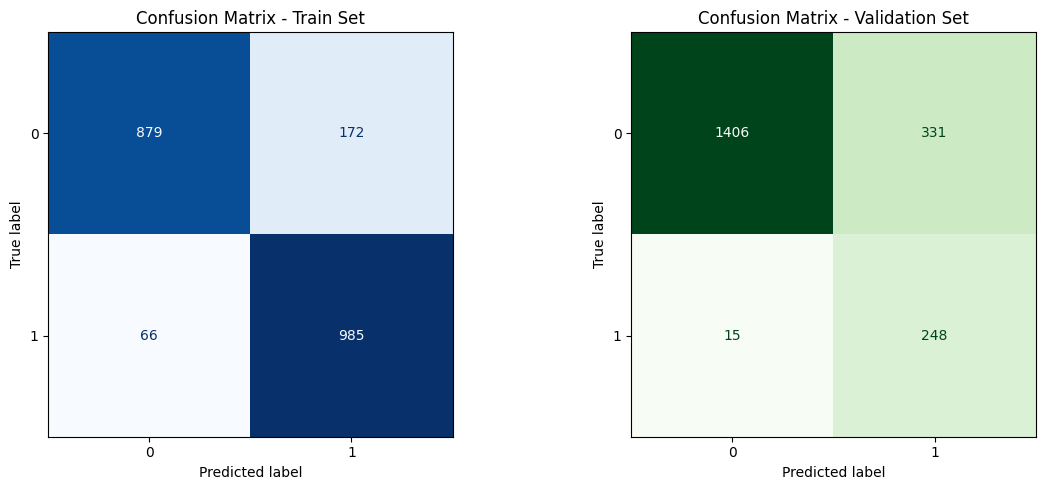

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train predictions
y_train_pred = best_model.predict(X_train_us_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train_us, y_train_pred, ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Confusion Matrix - Train Set")

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title("Confusion Matrix - Validation Set")

plt.tight_layout()
plt.show()


#### ROC Curve

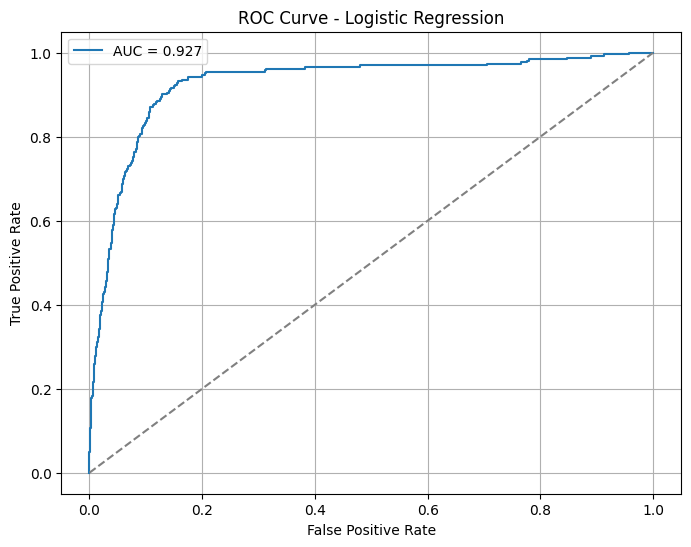

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

best_model = grid_search.best_estimator_
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
auc_score = roc_auc_score(y_val, y_val_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


#### Features Importance

In [13]:
import numpy as np

# Extract and display coefficients
coefs = best_model.coef_[0]
features = X_train_us_scaled.columns
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefs
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

print("🔍 Logistic Regression - Feature Importance (sorted by magnitude):")
print(coef_df[['Feature', 'Coefficient']])


🔍 Logistic Regression - Feature Importance (sorted by magnitude):
                Feature  Coefficient
3         response_time    -7.892158
5             is_urgent    -1.730473
0            unit_price    -1.268823
2     performance_score     1.050178
1         delivery_days    -0.706322
4  rfq_complexity_score    -0.609255
6             is_custom     0.206756


C:\Users\lucas\AppData\Local\Temp\ipykernel_24352\3572712529.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')


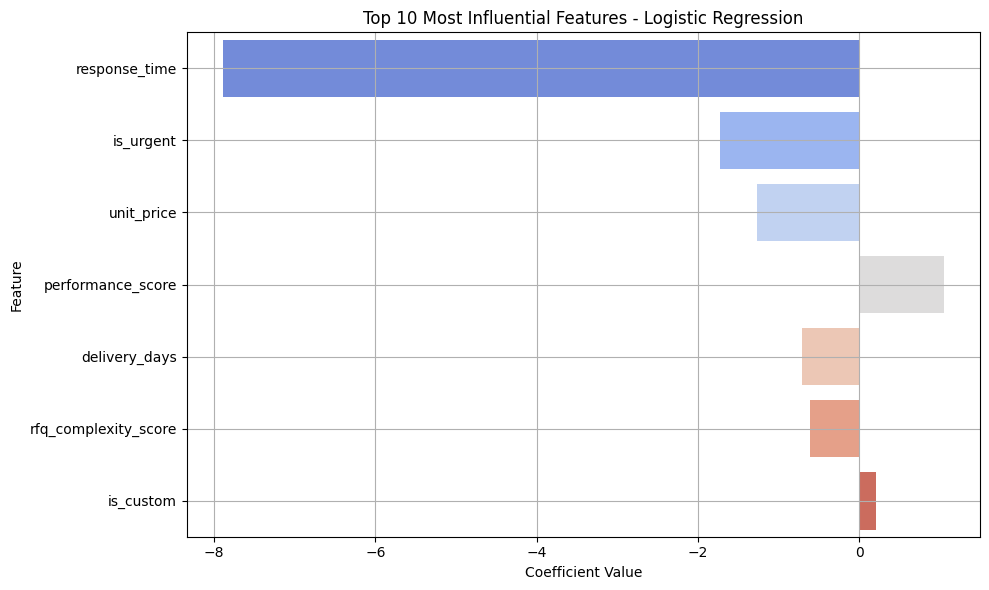

In [14]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Top 10 Most Influential Features - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpreting Feature Importance — Logistic Regression
The table above displays the feature coefficients from the trained Logistic Regression model, sorted by absolute magnitude. In this context, coefficients indicate the influence of each feature on the likelihood of a quotation being accepted (i.e., predicting class 1).

* Negative coefficients (e.g., ```response_time```, ```unit_price```) are associated with a lower probability of quote acceptance. For example, a longer response time or a higher unit price reduces the chances of winning the deal.

* Positive coefficients (e.g., ```performance_score```, ```rfq_complexity_score```) increase the probability of acceptance, suggesting that strong supplier performance or moderately complex RFQs may positively influence outcomes.

The magnitude of the coefficient reflects feature importance:

```Response time``` stands out as the most influential feature, indicating that timeliness is critical in winning quotations.

* Binary features such as ```is_urgent``` and ```is_custom``` also play a meaningful role in shaping quote outcomes, reflecting how urgency and customisation may affect client decisions.

* These insights can be used not only for prediction but also for improving operational strategy—for example, prioritising faster response mechanisms or flagging high-risk RFQs.

### Calibration Curve

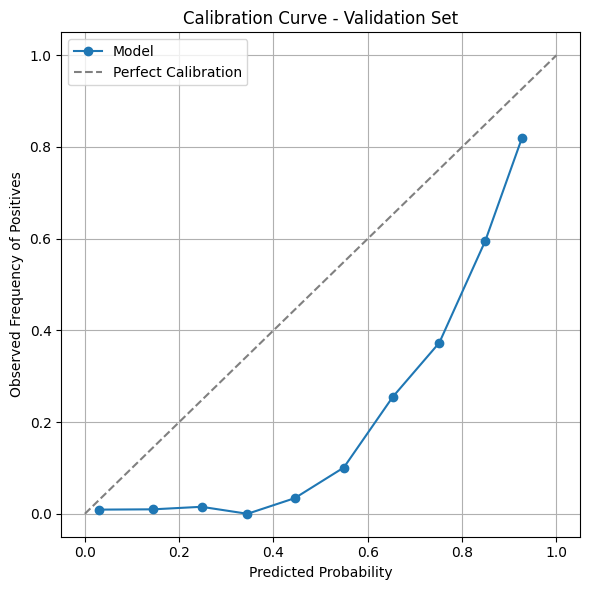

In [21]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Predicted probabilities on validation set
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Compute calibration curve
true_fraction, predicted_prob = calibration_curve(y_val, y_val_proba, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(predicted_prob, true_fraction, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency of Positives')
plt.title('Calibration Curve - Validation Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Probability Histogram by Class

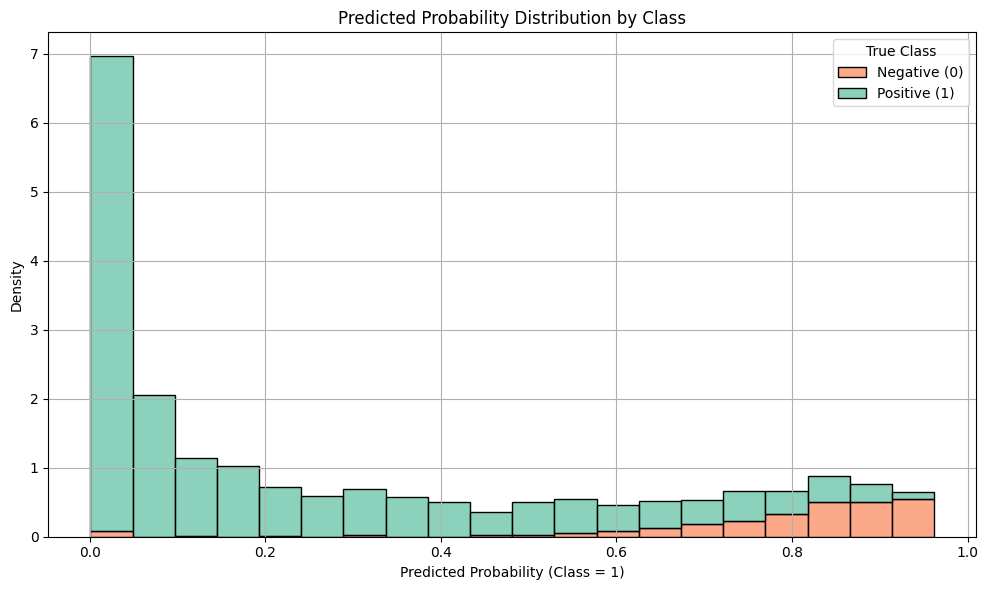

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame with predicted probabilities and true labels
proba_df = pd.DataFrame({
    'Predicted_Probability': y_val_proba,
    'Actual_Label': y_val
})

plt.figure(figsize=(10, 6))
sns.histplot(data=proba_df, x='Predicted_Probability', hue='Actual_Label', bins=20, kde=False, stat='density', palette='Set2', multiple='stack')

plt.title('Predicted Probability Distribution by Class')
plt.xlabel('Predicted Probability (Class = 1)')
plt.ylabel('Density')
plt.legend(title='True Class', labels=['Negative (0)', 'Positive (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()


------------

# Saving Model and Scaler

In [17]:
import joblib
import os

models_dir = "../models/"
os.makedirs(models_dir, exist_ok=True)

# Save model and scaler in the .src/models/ folder
joblib.dump(best_model, os.path.join(models_dir, "best_logistic_model.pkl"))
joblib.dump(scaler, os.path.join(models_dir, "minmax_scaler.pkl"))

print("✅ Model and scaler saved successfully in .src/models/")



✅ Model and scaler saved successfully in .src/models/


-------------

# Test set prediction

We use our trained binary classifier to estimate the probability that each test sample belongs to class 1 (i.e., the quote will be accepted). These probabilities—stored in the `'won'` column—serve as dynamic acceptance scores used later in the quote optimization process.


In [15]:
# Copy test data (with all features, 'won' is null)
df_test_copy = df_test.copy()

# Ensure the same column order and names
X_test = df_test_copy.drop(columns=['id', 'won'])

# Apply same MinMax scaling only to non-binary columns
X_test_scaled = X_test.copy()
X_test_scaled[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

# Get acceptance probabilities (class 1)
test_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

# Insert acceptance scores into the dataframe
df_test_copy['won'] = test_probabilities



In [17]:
df_test_copy.sample(5)

,id,unit_price,delivery_days,performance_score,response_time,rfq_complexity_score,is_urgent,is_custom,won
198,199,14.34,6,4.77,2.0,2.91,1,0,0.678209
88,89,12.16,6,4.77,2.0,3.28,1,1,0.760406
421,422,12.43,9,4.10,2.0,3.00,1,0,0.630581
157,158,10.08,5,3.17,2.0,2.73,0,0,0.945277
155,156,10.61,5,4.85,2.0,2.74,0,0,0.958085


In [18]:
import sqlite3
sqlite3.connect("../data/quotations.db").close()
